In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `C:\AlpOkul\TUe_Masters\Internship_BIASLab\CVI_AlpSemih\Project.toml`


In [2]:
using Random,LinearAlgebra, Flux.Optimise, Plots, ForneyLab
using ForneyLab:ParamStr2,KL_bc

In [3]:
Random.seed!(1234);

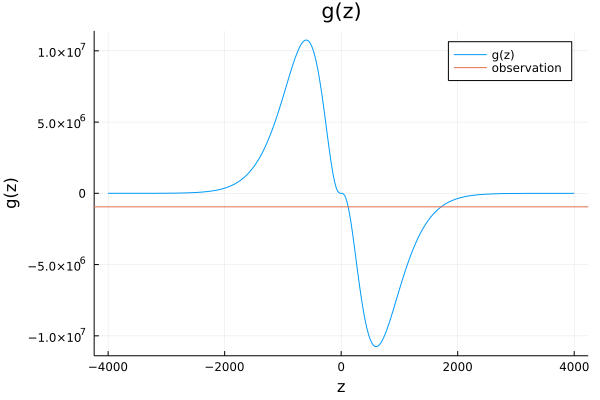

In [4]:
# Data and the Underlying Function
true_value = 120.0
N=10
# σ(x) = 1/(1+exp(-x))
f(x)=(x^3)*exp(-0.005*abs(x))*-1
y_obs = Vector{Float64}(undef,N)
for i=1:N
    y_obs[i] = f(true_value)+1*randn()
end

x_range = -4000:1:4000
y_plot = f.(x_range)
plot(x_range,y_plot,label="g(z)")
hline!([y_obs[1]],label="observation")
title!("g(z)")
xlabel!("z")
ylabel!("g(z)")

In [5]:
s_out = 1e4
μ_out = f(120)
msg_out = Message(Univariate, GaussianWeightedMeanPrecision,xi=s_out*μ_out,w=s_out)
sample(μ,S) = μ+sqrt(S)*randn()

λ_prior=[0,0.01]
FE(μ,S) = KL_bc([μ,S],λ_prior,msg_out.dist)-mean([logPdf(msg_out.dist,f.(sample(μ,S))) for x in 1:100])

FE (generic function with 1 method)

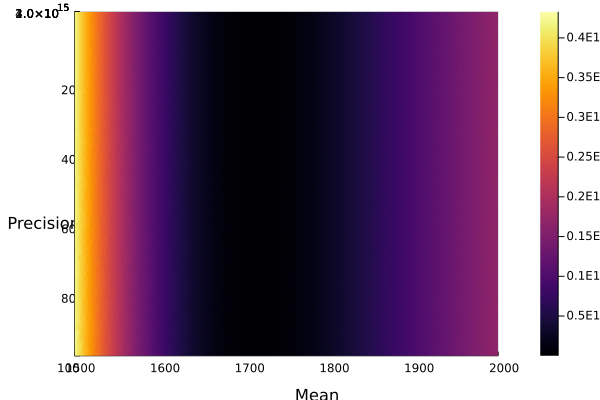

In [6]:
μ_arr = 1500:1:2000
S_arr = 1:1:100
FE_surf = zeros(size(μ_arr)[1],size(S_arr)[1])
for i in 1:size(μ_arr)[1],j in 1:size(S_arr)[1]
    FE_surf[i,j] = FE(μ_arr[i],S_arr[j])
end
plot(S_arr,μ_arr,FE_surf,st=:surface,camera=(90,90))
xlabel!("Precision")
ylabel!("Mean")

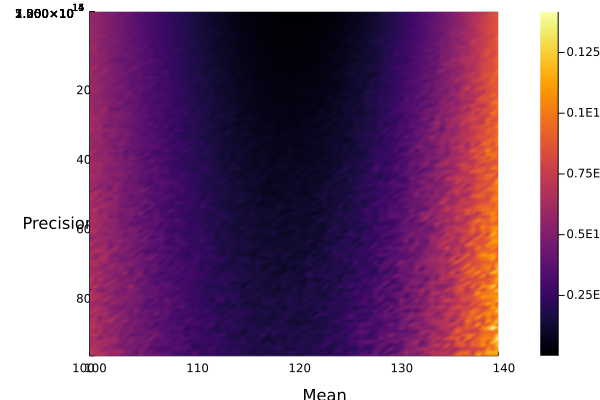

In [7]:
μ_arr = 100:0.5:140
S_arr = 1:1:100
FE_surf = zeros(size(μ_arr)[1],size(S_arr)[1])
for i in 1:size(μ_arr)[1],j in 1:size(S_arr)[1]
    FE_surf[i,j] = FE(μ_arr[i],S_arr[j])
end
plot(S_arr,μ_arr,FE_surf,st=:surface,camera=(90,90))
xlabel!("Precision")
ylabel!("Mean")

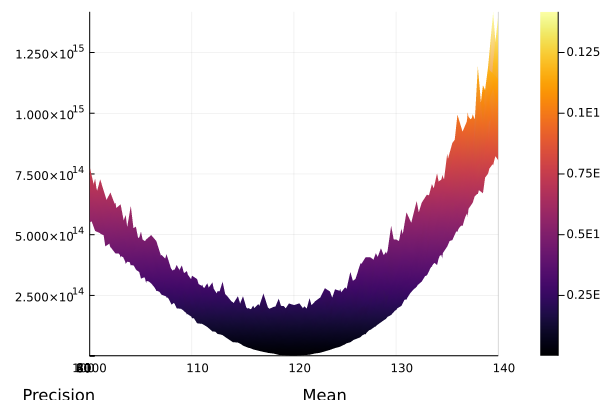

In [8]:
plot(S_arr,μ_arr,FE_surf,st=:surface,camera=(90,0))
xlabel!("Precision")
ylabel!("Mean")

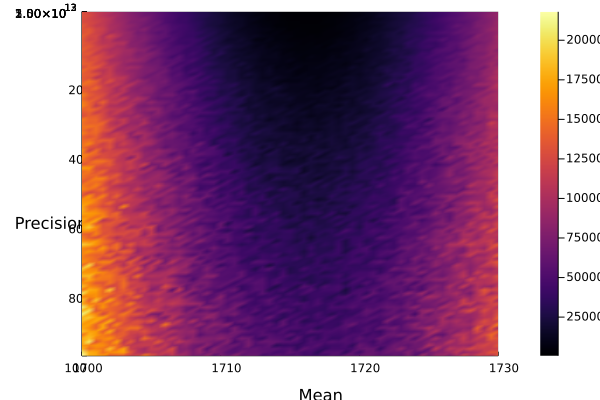

In [9]:
μ_arr = 1700:0.5:1730
S_arr = 1:1:100
FE_surf = zeros(size(μ_arr)[1],size(S_arr)[1])
for i in 1:size(μ_arr)[1],j in 1:size(S_arr)[1]
    FE_surf[i,j] = FE(μ_arr[i],S_arr[j])
end
plot(S_arr,μ_arr,FE_surf,st=:surface,camera=(90,90))
xlabel!("Precision")
ylabel!("Mean")

# Sampling

In [10]:
g=FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Nonlinear{Sampling}(x, g=f, n_samples=1000)
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm([x, m])
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
# Execute algorithm
marginals2 = Dict()
for i=1:N
    global marginals2
    data = Dict(:y => y_obs[i])
    marginals2 = step!(data)
    println("Sampling result = $(mean(marginals2[:x]))")
end

Sampling result = 1716.2395436699082
Sampling result = 1716.2389700389479
Sampling result = 1716.2391020952946
Sampling result = 1716.2389696594187
Sampling result = 1716.2395427146978
Sampling result = 1716.2399796369343
Sampling result = 1716.2394351966057
Sampling result = 1716.2391743202058
Sampling result = 1716.2394253137993
Sampling result = 1716.2390947980543


# Without Initial Step Size

### No Convergence Algo, Automatic Step Size, Constant Step Size

In [11]:
num_samples = 1000
g = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Cvi(x,g=f,opt=ParamStr2(convergence_algo = "none",burn_in_min=0.5,verbose=true),num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(x)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs[1])
    marginals = step!(data,marginals)
    println(mean(marginals[:x]))
end

inexactLineSearch succeeded, setting initial stepsize to 1.519495417550335e-7
Warning, fitted Pareto shape parameter =1.0929931490896903>=0.7!
119.99996500592094
Warning, fitted Pareto shape parameter =1.0926751507885013>=0.7!
119.99993351038813
Importance ratios are 0, fitted Pareto shape parameter = NaN
-2.680008994143182
Warning, fitted Pareto shape parameter =1.0936363002959228>=0.7!
119.99995180072803
Warning, fitted Pareto shape parameter =1.093720807765005>=0.7!
119.99991778534304
Importance ratios are 0, fitted Pareto shape parameter = NaN
-2359.257774045812
Warning, fitted Pareto shape parameter =1.0930488628181776>=0.7!
119.99997515491091
Warning, fitted Pareto shape parameter =1.09307616752421>=0.7!
119.99989304026066
Warning, fitted Pareto shape parameter =1.0922250712943442>=0.7!
120.00007653043666
Importance ratios are 0, fitted Pareto shape parameter = NaN
-2.1528357293427645


### MCMC Convergence Algo, Automatic Step Size, Constant Step Size

In [12]:
# num_samples = 1000
# g = FactorGraph()
# @RV x ~ GaussianMeanVariance(1.0, 100.0)
# @RV m ~ Cvi(x,g=f,opt=ParamStr2(convergence_algo = "MonteCarlo",verbose=true),num_samples=num_samples,num_iterations=Int64(1))
# @RV y ~ GaussianMeanVariance(m, 100.0)
# placeholder(y, :y)
# # Infer algorithm
# pfz = PosteriorFactorization(g)
# algo = messagePassingAlgorithm(x)
# source_code = algorithmSourceCode(algo)
# eval(Meta.parse(source_code));
# marginals = Dict()
# for i=1:N
#     data = Dict(:y => y_obs[1])
#     marginals = step!(data,marginals)
#     println(mean(marginals[:x]))
# end

### Free Energy Convergence Algo, Automatic Step Size, Constant Step Size

In [13]:
num_samples = 1000
g = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Cvi(x,g=f,opt=ParamStr2(convergence_algo = "free_energy",verbose=true),num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(x)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs[1])
    marginals = step!(data,marginals)
    println(mean(marginals[:x]))
    println("---")
end

inexactLineSearch succeeded, setting initial stepsize to 1.7144375793181215e-6
FE (4.506233569926763e9) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Importance ratios are 0, fitted Pareto shape parameter = NaN
-7.242370779932787
---
FE (1.5937804429007377e7) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =1.0983884752619864>=0.7!
119.99992948423375
---
FE (1.579907724511404e7) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =1.098399985744094>=0.7!
119.99992346974409
---
FE (1.5929406322391419e7) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =1.0983645935347603>=0.7!
119.99993431988243
---
FE (4.500895548774229e9) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Importance ratios are 0, fitted Pareto shape parameter = NaN
-4.925749197803599
---
FE (8.081751657084117e9) is smaller now,FE_check starts when i=52

# Initial Step Size Given

### Free Energy Convergence Algo, Inital Step Size Given, Constant Step Size

In [14]:
num_samples = 1000
g = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Cvi(x,g=f,opt=ParamStr2(eta=1e-8,convergence_algo = "free_energy",verbose=true),num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(x)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs[1])
    marginals = step!(data,marginals)
    println(mean(marginals[:x]))
    println("---")
end

FE (801620.7628366469) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =1.0114090041425952>=0.7!
119.99989051275891
---
FE (801792.674239344) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =1.0188910353652816>=0.7!
119.9998963388607
---
FE (801567.8171956004) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =1.0057042120204671>=0.7!
119.9999558157606
---
FE (801709.9296984752) is smaller now,FE_check starts when i=52000
Warning, fitted Pareto shape parameter =0.9948842377305864>=0.7!
119.99992873553413
---
FE (4.501616643460149e9) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Importance ratios are 0, fitted Pareto shape parameter = NaN
-6.5662293418753945
---
FE (4.49695603805703e9) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Importance ratios are 0, fitted Pareto shape parameter = NaN
-2.128404204144831
---

In [15]:
num_samples = 1000
g = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Cvi(x,g=f,opt=ParamStr2(eta=1e-8,convergence_algo = "none",verbose=true),num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(x)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs[1])
    marginals = step!(data,marginals)
    println(mean(marginals[:x]))
    println("---")
end

Importance ratios are 0, fitted Pareto shape parameter = NaN
-2.886807303437156
---
Importance ratios are 0, fitted Pareto shape parameter = NaN
-3.7562345342402867
---
Importance ratios are 0, fitted Pareto shape parameter = NaN
-2.0808390772313916
---
Warning, fitted Pareto shape parameter =1.0187074147327055>=0.7!
120.00001589718373
---
Warning, fitted Pareto shape parameter =1.0115854351408091>=0.7!
119.99991304934997
---
Importance ratios are 0, fitted Pareto shape parameter = NaN
-3.299127739164138
---
Warning, fitted Pareto shape parameter =0.9984248934043046>=0.7!
119.99994488394178
---
Warning, fitted Pareto shape parameter =1.028309810442997>=0.7!
120.00003043698247
---
Warning, fitted Pareto shape parameter =1.0059676883894042>=0.7!
120.00001913005426
---
Warning, fitted Pareto shape parameter =1.0195169875127525>=0.7!
119.99998819601721
---


# Adaptive StepSize

In [16]:
num_samples = 1000
g = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Cvi(x,g=f,opt=ParamStr2(stepsize_update="adaptive",convergence_algo = "none",verbose=true),num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(x)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs[1])
    marginals = step!(data,marginals)
    println(mean(marginals[:x]))
    println("---")
end

Warning, fitted Pareto shape parameter =1.0944731678470063>=0.7!
119.9999535096396
---
Warning, fitted Pareto shape parameter =1.0946535514016982>=0.7!
119.99995346808146
---
Warning, fitted Pareto shape parameter =1.0946304635820807>=0.7!
119.99995434593546
---
Warning, fitted Pareto shape parameter =1.0971216041894338>=0.7!
119.99995403029064
---
Warning, fitted Pareto shape parameter =1.0984798288944242>=0.7!
119.99995389085547
---
Warning, fitted Pareto shape parameter =1.0951114869794196>=0.7!
119.9999535004247
---
Warning, fitted Pareto shape parameter =1.0520737824037814>=0.7!
119.99994956781032
---
Warning, fitted Pareto shape parameter =1.0868293982729362>=0.7!
119.99995249481807
---
Warning, fitted Pareto shape parameter =1.0947464444019346>=0.7!
119.99995445688936
---
Warning, fitted Pareto shape parameter =1.0785766004384223>=0.7!
119.99995215556949
---


In [17]:
num_samples = 1000
g = FactorGraph()
@RV x ~ GaussianMeanVariance(1.0, 100.0)
@RV m ~ Cvi(x,g=f,opt=ParamStr2(stepsize_update="adaptive",convergence_algo = "free_energy",verbose=true),num_samples=num_samples,num_iterations=Int64(1))
@RV y ~ GaussianMeanVariance(m, 100.0)
placeholder(y, :y)
# Infer algorithm
pfz = PosteriorFactorization(g)
algo = messagePassingAlgorithm(x)
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
marginals = Dict()
for i=1:N
    data = Dict(:y => y_obs[1])
    marginals = step!(data,marginals)
    println(mean(marginals[:x]))
    println("---")
end

FE (4.506136356410406e9) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Warning, fitted Pareto shape parameter =1.0221124711964589>=0.7!
119.99994203486432
---
FE (1.8057931236218187e8) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Warning, fitted Pareto shape parameter =1.0972899535511547>=0.7!
119.9999537651439
---
FE (1.805781072057735e8) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Warning, fitted Pareto shape parameter =1.090012374664875>=0.7!
119.99995472367907
---
FE (1.8057733979972488e8) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Warning, fitted Pareto shape parameter =1.0892757787120273>=0.7!
119.99995519158226
---
FE (1.8057999402623734e8) is smaller now,FE_check starts when i=52000
Algorithm converged at iteration 92000
Warning, fitted Pareto shape parameter =1.0854543395566227>=0.7!
119.99995258566177
---
FE (1.8057962884679